In [ ]:
!pip install pyspark

In [ ]:
import pyspark
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,StandardScaler,PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,mean,avg,max
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import DataFrame
from pyspark.ml.feature import Imputer
import pandas as pd
from pyspark.sql.functions import col

In [ ]:
spark = SparkSession.builder.appName('customer churn').getOrCreate()

In [ ]:
class SmartEncoder():

    use_onehot = False
    use_std_scaler = False
    use_pca = False


    def __init__(self, df1,pred,use_oversampler,use_onehot, use_std_scaler,use_pca):
        print("Constructor of Class samrtencoder ")

        self.df1 = df1
        self.pred = pred
        self.use_oversampler = use_oversampler
        self.use_onehot = use_onehot
        self.use_std_scaler = use_std_scaler
        self.pca = use_pca

    @staticmethod
    def checkNulls(df):
        null_cols = {col:df.filter(df[col].isNull()).count() for col in df.columns}
        return null_cols
    @staticmethod
    def checkDuplicates(df):
        if df.count() > df.dropDuplicates().count():
            raise ValueError('Data has duplicates')


    def handlingMissingVal(self):

        #drop cols when the whole row is null
        df= self.df1.na.drop(how = "all")
        #drop duplicates
        df = df.dropDuplicates()
        #Treating missing values
        cols_to_drop = [x for x in df.columns if df.filter(df[x].isNull()).count()>0]
        if len(cols_to_drop) != 0:
            dff=df.select(cols_to_drop)
            continuousCols =[item[0] for item in dff.dtypes if item[1] != 'string']
            imputer = Imputer(inputCols=continuousCols, outputCols=continuousCols).setStrategy("mean")
            model = imputer.fit(df)
            imputed_data = model.transform(df)

        else:
            imputed_data = df

        return imputed_data

    def indexString(self):

        imputed = self.handlingMissingVal()
        if self.use_oversampler == True:
                imputed = self.oversmaple(imputed)

        #index the string to numeric
        self.stringCols = [item[0] for item in imputed.dtypes if item[1] == 'string']
        if len(self.stringCols) != 0:
            outputs=[y+"_encoded" for y in self.stringCols]
            stringIndexer = StringIndexer(inputCols=self.stringCols, outputCols=outputs)
            model = stringIndexer.fit(imputed)
            result = model.transform(imputed)

            encoded = result.drop(*self.stringCols)

            if self.use_onehot == True:
                #converting categorical attributes into a binary vector
                encoder = OneHotEncoder(dropLast=False, inputCols=outputs, outputCols=[x + "_vec" for x in self.stringCols])
                encoded2 = encoder.fit(encoded).transform(encoded)

                encoded = encoded2.drop(*outputs)
            encoded = encoded.withColumnRenamed(self.pred + '_encoded',self.pred)
            encoded = encoded.withColumnRenamed(self.pred + '_vec',self.pred)
        else:
            encoded = imputed

        return encoded

    def oversmaple(self,df):
        # example of random oversampling to balance the class distribution
        from collections import Counter
        from imblearn.over_sampling import RandomOverSampler
        dfp = df.toPandas()
        # define oversampling strategy
        oversample = RandomOverSampler()
        # fit and apply the transform
        data, y = oversample.fit_resample(dfp.loc[:,dfp.columns!=self.pred], dfp[self.pred])
        data[self.pred] = y
        df_sample = spark.createDataFrame(data)
        # summarize class distribution
        print(Counter(y))

        return df_sample

#**************************************************************#
    def dataAssembler(self,drops):
        # VectorAssembler - tranform features into a feature vector column
        encoded = self.indexString()
        encoded = encoded.drop(*drops)
        assembler = VectorAssembler(inputCols = encoded.drop(self.pred).columns, outputCol = 'features')
        df_Assembled = assembler.transform(encoded)

        if self.use_std_scaler == True:
            # standardize the dataframe to ensure that all the variables are around the same scale
            scale=StandardScaler(inputCol='features',outputCol='standardized')
            df_scale=scale.fit(df_Assembled)
            df_Assembled=df_scale.transform(df_Assembled)

        if self.pca == True:
            pca = PCA(k=3, inputCol=df_Assembled.columns[-1])
            pca.setOutputCol("pca_features")

            model = pca.fit(df_Assembled)
            df_Assembled = model.transform(df_Assembled)


        return df_Assembled


In [ ]:
df = spark.read.csv('drive/MyDrive/customer.csv', header = True, inferSchema = True)

In [ ]:
df.count()

900

In [ ]:
df.show(5)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|  Cynthia Norton|37.0|    

In [ ]:
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [ ]:
df.describe().show()

+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|summary|        Names|              Age|   Total_Purchase|   Account_Manager|            Years|         Num_Sites|            Location|             Company|              Churn|
+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|  count|          900|              900|              900|               900|              900|               900|                 900|                 900|                900|
|   mean|         NULL|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|                NULL|                NULL|0.16666666666666666|
| stddev|         NULL|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.764835592035

In [ ]:
SmartEncoder.checkNulls(df)

{'Names': 0,
 'Age': 0,
 'Total_Purchase': 0,
 'Account_Manager': 0,
 'Years': 0,
 'Num_Sites': 0,
 'Onboard_date': 0,
 'Location': 0,
 'Company': 0,
 'Churn': 0}

In [ ]:
df.select('Onboard_date').distinct().count()

900

In [ ]:
df = df.drop('Onboard_date')

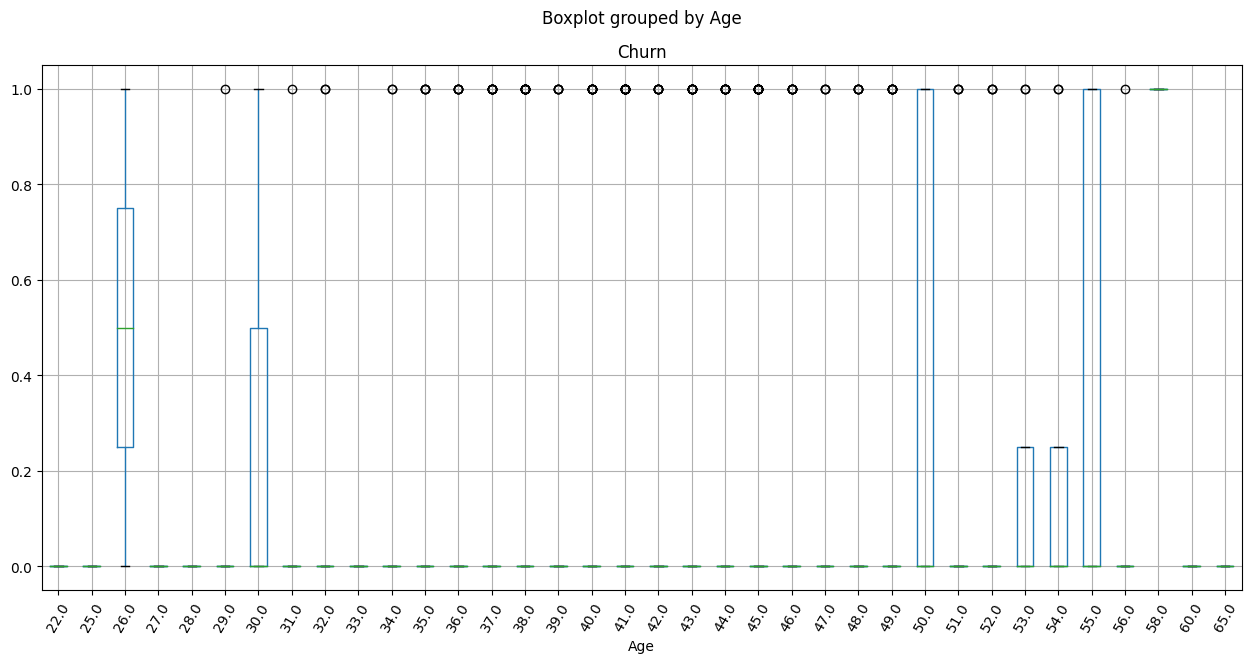

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
df.toPandas().boxplot('Churn', 'Age', rot=60,ax=ax)
# Show the plot
plt.show()

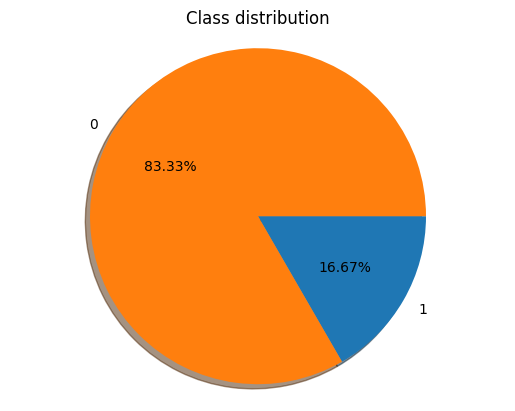

In [ ]:
# Class (Target) Distribution
class_dis=df.groupBy("Churn").count().toPandas()
class_occur = class_dis['count']
#class_names = ['churn','Not churn']
class_names = class_dis['Churn']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

In [ ]:
obj = SmartEncoder(df,'Churn',True,True,True,False)

Constructor of Class samrtencoder 


In [ ]:
df.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Location',
 'Company',
 'Churn']

In [ ]:
dfr = obj.indexString()
dfr.count()

Counter({0: 750, 1: 750})


1500

In [ ]:
dfr.columns

['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Churn',
 'Names_vec',
 'Location_vec',
 'Company_vec']

In [ ]:
dfr.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: long (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: long (nullable = true)
 |-- Names_vec: vector (nullable = true)
 |-- Location_vec: vector (nullable = true)
 |-- Company_vec: vector (nullable = true)



In [ ]:
dfr.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  750|
|    1|  750|
+-----+-----+



In [ ]:
dfr.show(1)

+----+--------------+---------------+-----+---------+-----+-----------------+-----------------+-----------------+
| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|        Names_vec|     Location_vec|      Company_vec|
+----+--------------+---------------+-----+---------+-----+-----------------+-----------------+-----------------+
|37.0|      11430.75|              0| 5.99|     10.0|    0|(899,[558],[1.0])|(900,[626],[1.0])|(873,[393],[1.0])|
+----+--------------+---------------+-----+---------+-----+-----------------+-----------------+-----------------+
only showing top 1 row



<ipython-input-36-497cadce29a3>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hm.corr(), annot = True)


<Axes: >

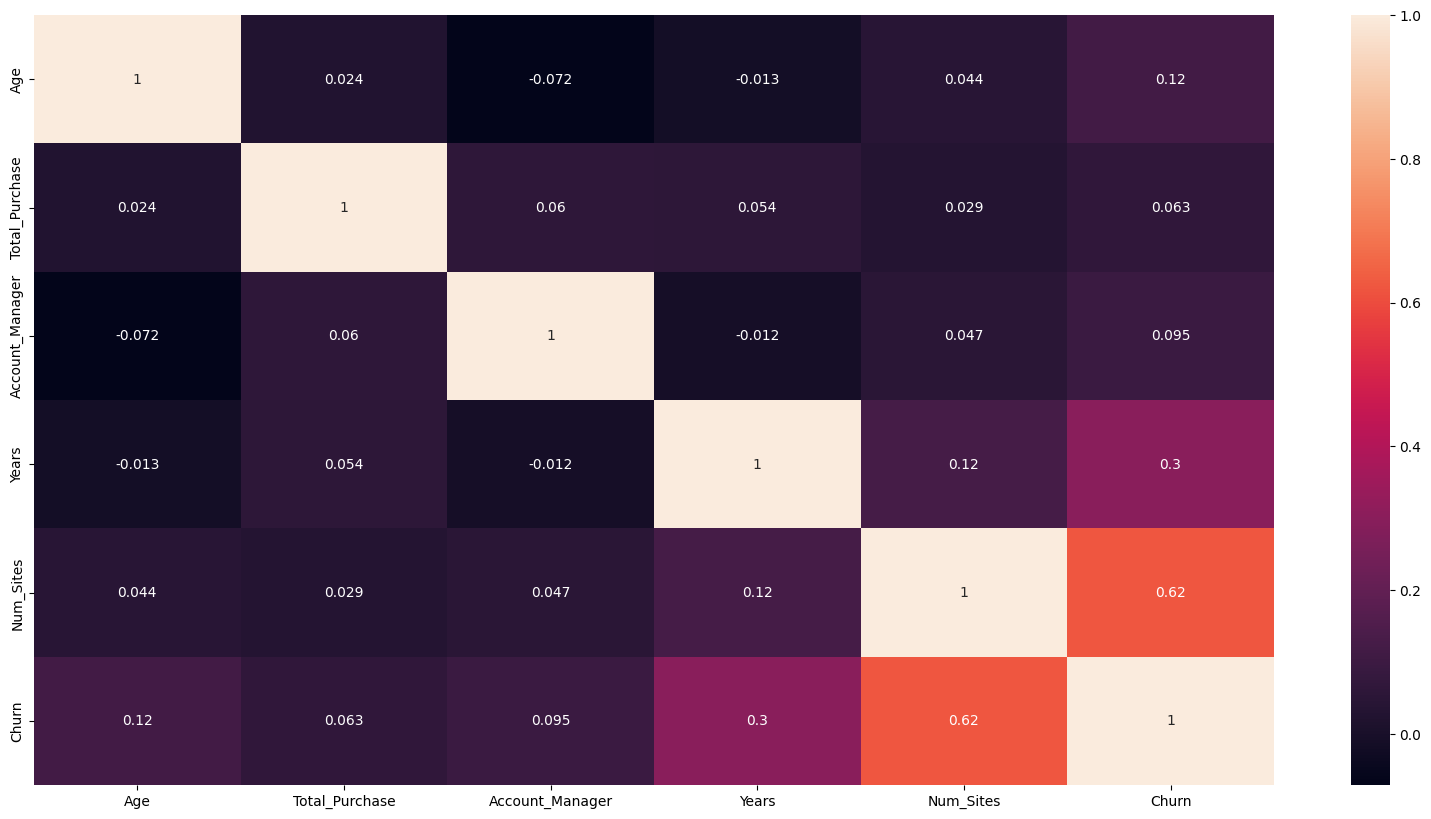

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
hm=dfr.toPandas()
plt.figure(figsize = (20, 10))
sns.heatmap(hm.corr(), annot = True)

In [ ]:
df_fin = obj.dataAssembler('')

Counter({0: 750, 1: 750})


In [ ]:
df_fin.columns

['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Churn',
 'Names_vec',
 'Location_vec',
 'Company_vec',
 'features',
 'standardized']

In [ ]:
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
class ClassificationEval():

    def __init__(self,pred,final_df):
        print("Constructor of Class for classification evaluation")
        self.final_df = final_df
        self.pred = pred
        self.accuresult ={}
        self.rocresult={}


    def run_on_model(self,model,featureCol):
        trainDF, testDF = self.final_df.randomSplit([0.7, 0.3], seed=42)
        if model == 'lr':
            lr = LogisticRegression(labelCol=self.pred, featuresCol=featureCol,maxIter=40)
            modellr =lr.fit(trainDF)
            self.predlr = modellr.transform(testDF)
            return self.predlr
        elif model == 'rf':
            rf = RandomForestClassifier(labelCol=self.pred, featuresCol=featureCol, numTrees=100, maxDepth=3)
            modelRf = rf.fit(trainDF)
            self.predrf = modelRf.transform(testDF)
            return self.predrf
        elif model == 'gb':
            gb = GBTClassifier(labelCol=self.pred,featuresCol=featureCol, maxIter=75, maxDepth=3)
            modelgb = gb.fit(trainDF)
            self.predgb = modelgb.transform(testDF)
            return self.predgb
        elif model == 'lsvc':
            lsvc = LinearSVC(labelCol=self.pred,featuresCol=featureCol, maxIter=10, regParam=0.1)
            lsvcModel = lsvc.fit(trainDF)
            self.predsvc = lsvcModel.transform(testDF)
            return self.predsvc
        else:
            raise ValueError('invalid model')


    def genMetrics(self,model, featureCol):

        pred_test = self.run_on_model(model,featureCol)
        binEval = BinaryClassificationEvaluator(labelCol=self.pred)
        evaluator = MulticlassClassificationEvaluator(labelCol=self.pred, predictionCol="prediction")
        self.accuresult[model] = evaluator.evaluate(pred_test,{evaluator.metricName: "accuracy"})
        self.rocresult[model] = binEval.evaluate(pred_test, {binEval.metricName: "areaUnderROC"})


    def run_all_model(self,featureCol):
        models = ['lr','rf','gb','lsvc']
        for model in models:
            self.genMetrics(model, featureCol)
        print("Accuracy =",self.accuresult)
        print("roc =",self.rocresult)
        return self.accuresult, self.rocresult



    def compareModel(self):
        best_v =0
        best_k=None
        for k,v in self.accuresult.items():
            if best_v < v:
                best_v=v
                best_k=k
        return best_k,best_v


In [ ]:
obj2 = ClassificationEval('Churn',df_fin)

Constructor of Class for classification evaluation


In [ ]:
accu, roc = obj2.run_all_model("features")

Accuracy = {'lr': 0.9417249417249417, 'rf': 0.8181818181818182, 'gb': 0.9300699300699301, 'lsvc': 0.9440559440559441}
roc = {'lr': 0.9996072270227808, 'rf': 0.9024177358819934, 'gb': 0.9575150562974601, 'lsvc': 0.999650868464694}


In [ ]:
 trainDF, testDF = df_fin.randomSplit([0.7, 0.3], seed=42)

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="Churn",featuresCol="features",maxIter=10)
gbtModel = gbt.fit(trainDF)
gbtPreds = gbtModel.transform(testDF)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
gbtEval = BinaryClassificationEvaluator(labelCol="Churn")
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))


Test Area Under ROC: 0.9578250032795487


In [ ]:
testDF.show()

+----+--------------+---------------+-----+---------+-----+-----------------+-----------------+-----------------+--------------------+--------------------+
| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|        Names_vec|     Location_vec|      Company_vec|            features|        standardized|
+----+--------------+---------------+-----+---------+-----+-----------------+-----------------+-----------------+--------------------+--------------------+
|26.0|       8787.39|              1| 5.42|     11.0|    1|(899,[100],[1.0])| (900,[95],[1.0])|(873,[111],[1.0])|(2677,[0,1,2,3,4,...|(2677,[0,1,2,3,4,...|
|28.0|       9090.43|              1| 5.74|     10.0|    0|(899,[600],[1.0])|(900,[233],[1.0])|(873,[308],[1.0])|(2677,[0,1,2,3,4,...|(2677,[0,1,2,3,4,...|
|28.0|      11245.38|              0| 6.72|      8.0|    0|(899,[254],[1.0])|(900,[438],[1.0])|(873,[865],[1.0])|(2677,[0,1,3,4,25...|(2677,[0,1,3,4,25...|
|29.0|       5900.78|              1| 5.56|      8.0|    0|(899,

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

# Run cross validations.
# This can take some minutes since it is training over 20 trees!
cvModel = cv.fit(trainDF)
cvPreds = cvModel.transform(testDF)
gbtEval.evaluate(cvPreds)

0.9647885784249421

In [ ]:
model_path = "Churn_model"
cvModel.write().overwrite().save(model_path)